In [1]:
from datasets import load_dataset, Dataset, DatasetDict, load_from_disk
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
api_key = 's'

In [3]:
from openai import OpenAI
client = OpenAI(api_key=api_key)

In [4]:
response = client.embeddings.create(
    input="Your text string goes here",
    model="text-embedding-3-small",
    dimensions = 512
)

In [5]:
response.data[0].embedding

[0.0074610635638237,
 0.02506347745656967,
 -0.02717922441661358,
 -0.026975788176059723,
 -0.06868043541908264,
 -0.04402383416891098,
 0.04021955654025078,
 0.005253768526017666,
 0.016305500641465187,
 0.00935303047299385,
 -0.002451419597491622,
 0.022988416254520416,
 -0.0018678088672459126,
 -0.011423004791140556,
 0.08707117289304733,
 0.07319674640893936,
 -0.040036462247371674,
 0.014413533732295036,
 -0.05871200934052467,
 0.07266780734062195,
 -0.0005610419902950525,
 0.04394245892763138,
 -0.019957199692726135,
 0.047929830849170685,
 0.025165194645524025,
 0.024432821199297905,
 -0.002567124553024769,
 0.029640816152095795,
 0.05932231992483139,
 -0.05480601266026497,
 -0.03804277628660202,
 -0.07270849496126175,
 0.03515396639704704,
 -0.08023567497730255,
 -0.04687195643782616,
 0.06151944398880005,
 0.09398803859949112,
 0.021360917016863823,
 -0.02270360477268696,
 -0.06009538099169731,
 0.032244812697172165,
 0.010700802318751812,
 0.06534406542778015,
 0.010283756069

In [6]:
def get_openai_embeddings(batch):
    english = batch['en']
    embeds_list = []

    response = client.embeddings.create(
    input= english, 
    model="text-embedding-3-small",
   # dimensions = 1024
    )
    for i, embedding in enumerate(response.data):
        embeds_list.append(embedding.embedding)
    
    return {'en_openai_embedding': embeds_list}

Load the dataset

In [13]:
data_to_embed = load_from_disk("results/datasets/sethjsa_medline_ru_mono_backtranslated_with_results_backtranslation_model_finetuned_on_medline.json", "train")
data_to_embed.shape

{'train': (32500, 2)}

In [15]:
dataset_with_embeddings = data_to_embed.map(
    get_openai_embeddings,
    batched=True,
    batch_size=256,
)

Map:   0%|          | 0/32500 [00:00<?, ? examples/s]

In [16]:
dataset_with_embeddings.save_to_disk('results/datasets/sethjsa_medline_ru_mono_backtranslated_with_results_backtranslation_model_finetuned_on_medline_openai_embeddings.json')

Saving the dataset (0/1 shards):   0%|          | 0/32500 [00:00<?, ? examples/s]

Find outliers in the data

In [3]:
dataset_with_embeddings_loaded = load_from_disk('results/datasets/sethjsa_medline_ru_mono_backtranslated_with_results_backtranslation_model_finetuned_on_medline_openai_embeddings.json', 'train')

In [4]:
from sklearn.ensemble import IsolationForest

In [5]:
dataset_with_embeddings = dataset_with_embeddings_loaded['train']

In [6]:
forest = IsolationForest(n_estimators=300, max_samples = 256) # try different contamination levels?

embeddings_array = np.array(dataset_with_embeddings['en_openai_embedding'])
forest.fit(embeddings_array)

predictions = forest.predict(embeddings_array)
anomaly_scores = forest.decision_function(embeddings_array)

In [7]:
dataset_with_embeddings = dataset_with_embeddings.add_column("is_outlier_prediction", predictions.tolist())
dataset_with_embeddings = dataset_with_embeddings.add_column("anomaly_score", anomaly_scores.tolist())

In [9]:
outliers_dataset = dataset_with_embeddings.filter(
    lambda example: example['is_outlier_prediction'] == -1
)
for i in range(len(outliers_dataset)):
    print(outliers_dataset[i])

Filter:   0%|          | 0/32500 [00:00<?, ? examples/s]

/scratch-local/scur2189.11947212/ipykernel_1073606/489261178.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


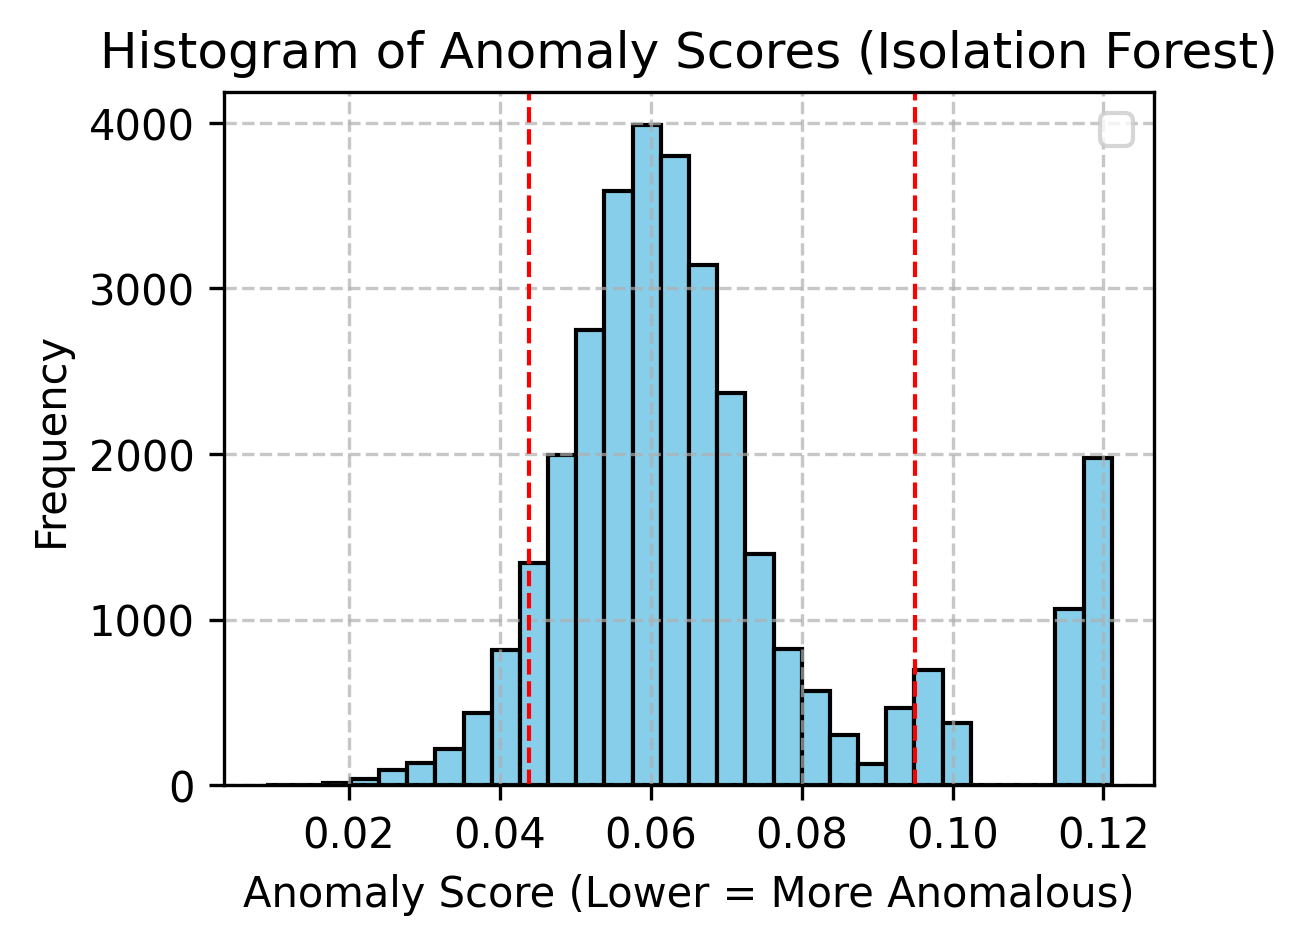

Min score: 0.0091
Max score: 0.1211
Mean score: 0.0670
Median score: 0.0622


In [8]:
plt.figure(figsize=(4, 3), dpi=300)
plt.hist(anomaly_scores, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Anomaly Scores (Isolation Forest)')
plt.xlabel('Anomaly Score (Lower = More Anomalous)')
plt.ylabel('Frequency')

# threshold_value = 0.04

plt.axvline(0.04389, color='red', linestyle='dashed', linewidth=1)
# plt.axvline(0.0396, color='blue', linestyle='dashed', linewidth=1)
# plt.axvline(0.11359, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(0.095, color='red', linestyle='dashed', linewidth=1)

outlier_scores = anomaly_scores[predictions == -1]
inlier_scores = anomaly_scores[predictions == 1]

plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print(f"Min score: {np.min(anomaly_scores):.4f}")
print(f"Max score: {np.max(anomaly_scores):.4f}")
print(f"Mean score: {np.mean(anomaly_scores):.4f}")
print(f"Median score: {np.median(anomaly_scores):.4f}")

In [11]:
sorted_indices = np.argsort(anomaly_scores,)
for i in range(1000):
    original_idx = sorted_indices[-i]

    example = dataset_with_embeddings[int(original_idx)]
    score_val = anomaly_scores[original_idx] 

    en_text_val = example.get('en')
    ru_text_val = example.get('ru')

    print(f"{i+1:<5} | {int(original_idx):<8} | {score_val:<12.4f} | {en_text_val} | {ru_text_val}")


1     | 27807    | 0.0109       | Most transmiters are expressioned during energyrogenesis, which was administered. | Большинство трансмиттеров экспрессируется во время эмбриогенеза.
2     | 12224    | 0.1172       | MATERIAL AND METHODS | Материал и методы.
3     | 12151    | 0.1172       | MATERIAL AND METHODS | Материал и методы.
4     | 12181    | 0.1172       | MATERIAL AND METHODS | Материал и методы.
5     | 12231    | 0.1172       | MATERIAL AND METHODS | Материал и методы.
6     | 4164     | 0.1172       | MATERIAL AND METHODS | Материалы и методы.
7     | 12216    | 0.1172       | MATERIAL AND METHODS | Материал и методы.
8     | 29015    | 0.1172       | MATERIAL AND METHODS | Материал и методы.
9     | 20595    | 0.1172       | MATERIAL AND METHODS | Материалы и методы.
10    | 20644    | 0.1172       | MATERIAL AND METHODS | Материалы и методы.
11    | 20703    | 0.1172       | MATERIAL AND METHODS | Материал и методы.
12    | 20677    | 0.1172       | MATERIAL AND METHODS

Remove 10% 

In [18]:
np.percentile(anomaly_scores, 95)

0.11359371378816911

In [ ]:
upper_threshold = np.percentile(anomaly_scores, 95)
lower_threshold = np.percentile(anomaly_scores, 5)
filtered_dataset = dataset_with_embeddings.filter(
    lambda ex: ex["anomaly_score"] < upper_threshold and ex["anomaly_score"] > lower_threshold
)

print(f"Original rows:  {dataset_with_embeddings.num_rows}")
print(f"Filtered rows: {filtered_dataset.num_rows}")

Filter:   0%|          | 0/32500 [00:00<?, ? examples/s]

Original rows:  32500
Filtered rows: 29250


In [9]:
unique_texts = set()
filtered_rows = []

for row in dataset_with_embeddings:
    if row['ru'] not in unique_texts:
        unique_texts.add(row['ru'])
        filtered_rows.append(row)

In [10]:
filtered_dataset = Dataset.from_dict({k: [d[k] for d in filtered_rows] for k in filtered_rows[0].keys()})

In [ ]:
filtered_dataset # 27505

Dataset({
    features: ['en', 'ru', 'en_openai_embedding', 'is_outlier_prediction', 'anomaly_score'],
    num_rows: 27505
})

In [12]:
filtered_dataset = filtered_dataset.remove_columns(['en_openai_embedding', 'is_outlier_prediction', 'anomaly_score'])

In [13]:
filtered_dataset.save_to_disk(
    "results/datasets/rq2/ru_duplicates_out_medline_ru_mono_backtranslated_with_results_backtranslation_model_finetuned_on_medline_openai_embeddings_filtered.json",
)

Saving the dataset (0/1 shards):   0%|          | 0/27505 [00:00<?, ? examples/s]